In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack, csr_matrix

# --- Descargar recursos de NLTK si no los tienes ---
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("El recurso 'stopwords' de NLTK no se encontró. Descargando...")
    nltk.download('stopwords')
    print("Descarga de 'stopwords' completada.")

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    print("El recurso 'wordnet' de NLTK no se encontró. Descargando...")
    nltk.download('wordnet')
    print("Descarga de 'wordnet' completada.")

El recurso 'wordnet' de NLTK no se encontró. Descargando...
Descarga de 'wordnet' completada.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Fabricio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# --- Clase para preprocesamiento de texto ---
class PreprocesadorTexto:
    def __init__(self):
        self.stop_words_en = set(stopwords.words('english'))
        self.stop_words_es = set(stopwords.words('spanish'))
        self.lemmatizer = WordNetLemmatizer()
        self.embedding_dim = 0  # Sin Sentence-BERT por simplicidad
        self.medical_translations = {
            'dolor de pecho': 'chest pain',
            'dolor de cabeza': 'headache',
            'fiebre': 'fever',
            'tos': 'cough',
            'vómito': 'vomiting',
            'mareo': 'dizziness',
            'dolor abdominal': 'abdominal pain',
            'diarrea': 'diarrhea',
            'palpitaciones': 'palpitations',
            'dolor de garganta': 'sore throat',
            'dolor muscular': 'muscle pain',
            'dolor lumbar': 'low back pain',
            'dolor de espalda': 'back pain',
            'dolor de estómago': 'stomach pain',
            'náuseas': 'nausea',
            'estreñimiento': 'constipation',
            'falta de aire': 'shortness of breath',
            'opresión en el pecho': 'chest tightness',
            'pérdida de conocimiento': 'loss of consciousness',
            'desmayo': 'fainting',
            'sudoración': 'sweating',
            'escalofríos': 'chills',
            'fatiga': 'fatigue',
            'cansancio': 'tiredness',
            'debilidad': 'weakness',
            'insomnio': 'insomnia',
            'ansiedad': 'anxiety',
            'depresión': 'depression',
            'dolor articular': 'joint pain',
            'dolor de pierna': 'leg pain',
            'dolor de brazo': 'arm pain',
            'dolor de cuello': 'neck pain',
            'dolor de oído': 'ear pain',
            'dolor ocular': 'eye pain',
            'sangrado': 'bleeding',
            'picazón': 'itching',
            'erupción': 'rash',
            'inflamación': 'swelling',
        }

    def detectar_idioma(self, texto):
        spanish_words = sum(1 for word in texto.split() if word.lower() in self.stop_words_es)
        english_words = sum(1 for word in texto.split() if word.lower() in self.stop_words_en)
        return 'spanish' if spanish_words > english_words else 'english'

    def traducir_texto(self, texto, idioma):
        if idioma == 'spanish':
            for es, en in self.medical_translations.items():
                texto = texto.replace(es, en)
            return texto
        return texto

    def limpiar_texto(self, texto):
        texto = texto.lower()
        texto = re.sub(r'[^\w\s]', '', texto)
        palabras = texto.split()
        palabras = [self.lemmatizer.lemmatize(word) for word in palabras if word not in self.stop_words_en]
        return ' '.join(palabras)

    def procesar_texto_completo(self, texto):
        idioma = self.detectar_idioma(texto)
        texto_traducido = self.traducir_texto(texto, idioma)
        texto_limpio = self.limpiar_texto(texto_traducido)
        return {
            'idioma_detectado': idioma,
            'texto_traducido': texto_traducido,
            'texto_limpio': texto_limpio,
            'tiene_embeddings': False,  # Sin embeddings por ahora
            'dimension_embeddings': self.embedding_dim
        }

In [4]:
# --- 1. Cargar los datos ---
print("🔄 Cargando datasets...")
try:
    df_reviews = pd.read_csv('datos/Independent_Medical_Reviews.csv')
    print("\nColumnas de Independent_Medical_Reviews.csv:")
    print(df_reviews.columns)
    print("\nPrimeras 5 filas de Independent_Medical_Reviews.csv:")
    print(df_reviews.head())
except FileNotFoundError:
    print("Error: Independent_Medical_Reviews.csv no encontrado.")
    df_reviews = None

try:
    df_processed = pd.read_csv('datos/processed_medical_data.csv')
    print("\nColumnas de processed_medical_data.csv:")
    print(df_processed.columns)
    print("\nPrimeras 5 filas de processed_medical_data.csv:")
    print(df_processed.head())
except FileNotFoundError:
    print("Error: processed_medical_data.csv no encontrado.")
    df_processed = None

🔄 Cargando datasets...

Columnas de Independent_Medical_Reviews.csv:
Index(['Reference ID', 'Report Year', 'Diagnosis Category',
       'Diagnosis Sub Category', 'Treatment Category',
       'Treatment Sub Category', 'Determination', 'Type', 'Age Range',
       'Patient Gender', 'Findings'],
      dtype='object')

Primeras 5 filas de Independent_Medical_Reviews.csv:
  Reference ID  Report Year      Diagnosis Category Diagnosis Sub Category  \
0   MN16-22639         2016              Infectious              Hepatitis   
1   MN16-22638         2016                  Mental        Eating Disorder   
2   MN16-22637         2016         Autism Spectrum         Autism-PDD-NOS   
3   EI16-22636         2016  Prevention/Good Health                    NaN   
4    EI06-5319         2006     Cardiac/Circulatory                    NaN   

                          Treatment Category  \
0                Pharmacy/Prescription Drugs   
1                    Mental Health Treatment   
2                 

In [5]:
#--- 2. Normalización y combinación de datasets ---
print("\n🔧 Normalizando y combinando datasets...")
def normalizar_edad(df, columna_edad):
    edad_mapping = {
        '0': '0-10', '1': '0-10', '2': '0-10', '3': '0-10', '4': '0-10', '5': '0-10',
        '6': '0-10', '7': '0-10', '8': '0-10', '9': '0-10', '10': '0-10',
        '11': '11-17', '12': '11-17', '13': '11-17', '14': '11-17', '15': '11-17',
        '16': '11-17', '17': '11-17', '18-30': '18-30', '31-40': '31-40',
        '41-50': '41-50', '51-64': '51-64', '65+': '65+', 'Unknown': 'Unknown'
    }
    return df[columna_edad].astype(str).map(edad_mapping).fillna('Unknown')

def normalizar_genero(df, columna_genero):
    genero_mapping = {
        'M': 'Male', 'Male': 'Male', 'MALE': 'Male', 'male': 'Male',
        'F': 'Female', 'Female': 'Female', 'FEMALE': 'Female', 'female': 'Female',
        'Unknown': 'Unknown', 'U': 'Unknown', 'Other': 'Unknown'
    }
    return df[columna_genero].astype(str).map(genero_mapping).fillna('Unknown')

# Preparar datasets
combined_df = pd.DataFrame()
preprocesador = PreprocesadorTexto()

if df_reviews is not None:
    df_reviews_temp = df_reviews[['Findings', 'Diagnosis Category', 'Age Range', 'Patient Gender']].copy()
    df_reviews_temp = df_reviews_temp.dropna(subset=['Findings', 'Diagnosis Category'])
    df_reviews_temp.rename(columns={
        'Findings': 'text_features',
        'Diagnosis Category': 'target_disease',
        'Age Range': 'age_feature',
        'Patient Gender': 'gender_feature'
    }, inplace=True)
    df_reviews_temp['age_feature'] = normalizar_edad(df_reviews_temp, 'age_feature')
    df_reviews_temp['gender_feature'] = normalizar_genero(df_reviews_temp, 'gender_feature')
    combined_df = pd.concat([combined_df, df_reviews_temp], ignore_index=True)
    print(f"✅ Añadido {len(df_reviews_temp)} filas de Independent_Medical_Reviews.csv")

if df_processed is not None:
    df_processed_temp = df_processed[['symptoms', 'diagnosis']].copy()
    df_processed_temp = df_processed_temp.dropna(subset=['symptoms', 'diagnosis'])
    df_processed_temp.rename(columns={
        'symptoms': 'text_features',
        'diagnosis': 'target_disease'
    }, inplace=True)
    df_processed_temp['age_feature'] = 'Unknown'
    df_processed_temp['gender_feature'] = 'Unknown'
    combined_df = pd.concat([combined_df, df_processed_temp], ignore_index=True)
    print(f"✅ Añadido {len(df_processed_temp)} filas de processed_medical_data.csv")

if combined_df.empty:
    print("❌ Error: No se pudo crear un DataFrame combinado válido.")
    exit()

print(f"\n✅ Dataset combinado creado: {len(combined_df)} filas")
print(f"Columnas combinadas: {combined_df.columns.tolist()}")
print("Top 10 diagnósticos:")
print(combined_df['target_disease'].value_counts().head(10))


🔧 Normalizando y combinando datasets...
✅ Añadido 19166 filas de Independent_Medical_Reviews.csv
✅ Añadido 446 filas de processed_medical_data.csv

✅ Dataset combinado creado: 19612 filas
Columnas combinadas: ['text_features', 'target_disease', 'age_feature', 'gender_feature']
Top 10 diagnósticos:
target_disease
Orthopedic/ Musculoskeletal              3468
Mental                                   2511
Cancer                                   1678
Central Nervous System/ Neuromuscular    1663
Infectious                               1058
Cardiac/Circulatory                       964
Morbid Obesity                            823
OB-Gyn/ Pregnancy                         799
Endocrine/ Metabolic                      779
Digestive System/ Gastrointestinal        757
Name: count, dtype: int64


In [6]:
# --- 3. Preprocesamiento de datos ---
print("\n🧹 Preprocesando datos...")
combined_df['text_features'] = combined_df['text_features'].apply(
    lambda x: preprocesador.procesar_texto_completo(x)['texto_limpio'] if isinstance(x, str) else ''
)

# Codificar variables categóricas
age_encoder = LabelEncoder()
gender_encoder = LabelEncoder()
diagnosis_encoder = LabelEncoder()

combined_df['age_feature'] = age_encoder.fit_transform(combined_df['age_feature'])
combined_df['gender_feature'] = gender_encoder.fit_transform(combined_df['gender_feature'])
combined_df['target_disease'] = diagnosis_encoder.fit_transform(combined_df['target_disease'])

# Vectorización de texto
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(combined_df['text_features'])

# Combinar características
X_categorical = csr_matrix(combined_df[['age_feature', 'gender_feature']].values)
X = hstack([X_tfidf, X_categorical])
y = combined_df['target_disease'].values


🧹 Preprocesando datos...


In [7]:
# --- 4. Entrenamiento del modelo ---
print("\n🚀 Entrenando modelo XGBoost...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_v11 = XGBClassifier(random_state=42, n_estimators=100, max_depth=6)
modelo_v11.fit(X_train, y_train)


🚀 Entrenando modelo XGBoost...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [8]:
# Predicciones y evaluación
y_pred = modelo_v11.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Precisión en test: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Reporte de clasificación
clases = diagnosis_encoder.classes_
print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=clases, zero_division=0))

✅ Precisión en test: 0.7568 (75.68%)

📋 Reporte de clasificación:


ValueError: Number of classes, 43, does not match size of target_names, 44. Try specifying the labels parameter

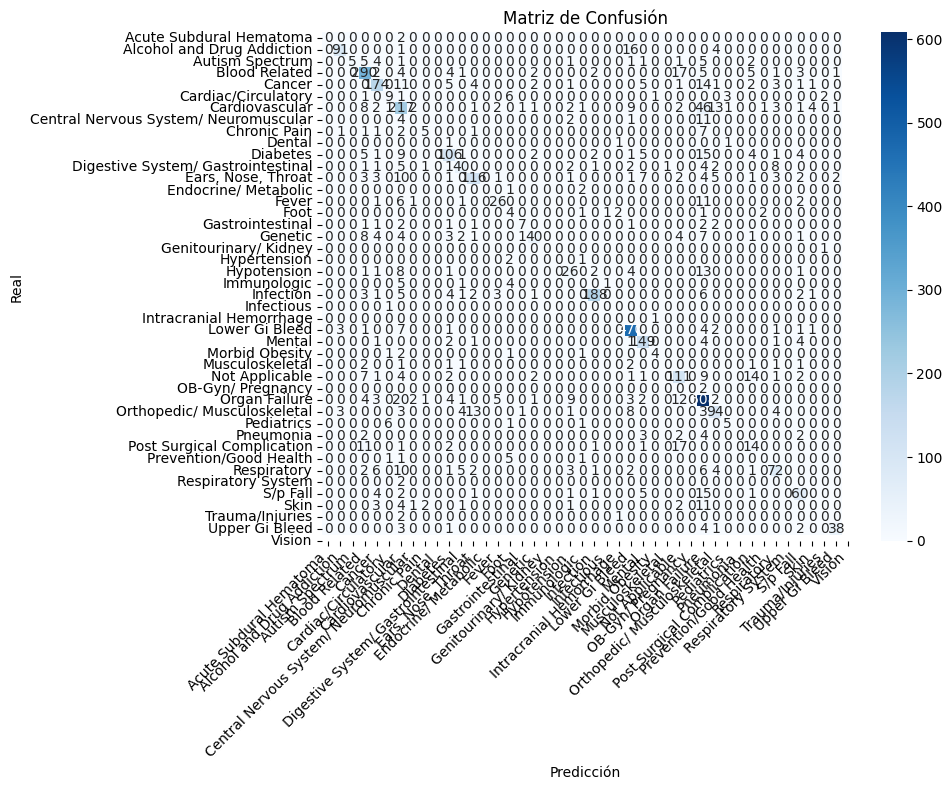

In [9]:
# Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
# --- 5. Guardado del modelo ---
print("\n💾 Guardando modelo v11...")
os.makedirs("models/v11_components", exist_ok=True)

with open('models/v11_components/modelo_xgb.pkl', 'wb') as f:
    pickle.dump(modelo_v11, f)
with open('models/v11_components/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
with open('models/v11_components/age_encoder.pkl', 'wb') as f:
    pickle.dump(age_encoder, f)
with open('models/v11_components/gender_encoder.pkl', 'wb') as f:
    pickle.dump(gender_encoder, f)
with open('models/v11_components/diagnosis_encoder.pkl', 'wb') as f:
    pickle.dump(diagnosis_encoder, f)

preprocesador_data = {
    'medical_translations': preprocesador.medical_translations,
    'embedding_dim': preprocesador.embedding_dim,
    'stop_words_en': list(preprocesador.stop_words_en),
    'stop_words_es': list(preprocesador.stop_words_es),
    'lemmatizer_available': preprocesador.lemmatizer is not None
}
with open('models/v11_components/preprocesador_data.pkl', 'wb') as f:
    pickle.dump(preprocesador_data, f)

metadata = {
    'clases': clases.tolist(),
    'precision': test_accuracy,
    'fecha': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'num_clases': len(clases),
    'embedding_dim': 0,
    'version': 'v11'
}
with open('models/v11_components/metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("✅ Modelo guardado exitosamente")


💾 Guardando modelo v11...
✅ Modelo guardado exitosamente
